In [1]:
import argparse
import sys

import an_cockrell
import matplotlib.pyplot as plt
import numpy as np
from an_cockrell import AnCockrellModel
from scipy.stats import multivariate_normal
from tqdm import trange

from consts import (
    UNIFIED_STATE_SPACE_DIMENSION,
    default_params,
    init_only_params,
    state_var_indices,
    state_vars,
    variational_params,
)
from modify_epi_spatial import modify_model
from util import model_macro_data

################################################################################

if hasattr(sys, "ps1"):
    # interactive mode
    args = object()
else:
    parser = argparse.ArgumentParser()

    parser.add_argument("--prefix", type=str, default="", help="output file prefix")

    parser.add_argument(
        "--measurements",
        type=str,
        choices=[
            "T1IFN",
            "TNF",
            "IFNg",
            "IL6",
            "IL1",
            "IL8",
            "IL10",
            "IL12",
            "IL18",
            "extracellular_virus",
        ],
        nargs="+",
        required=True,
        help="which things to measure (required)",
    )

    parser.add_argument(
        "--matchmaker",
        help="try to match resampled macrostates with microstate "
        "models to minimize change magnitude",
        type=str,
        choices=["yes", "no"],
        required=True,
    )

    parser.add_argument("--graphs", help="make pdf graphs", action="store_true")

    args = parser.parse_args()

VERBOSE = False


################################################################################
# constants


# layout for graphing state variables.
# Attempts to be mostly square, with possibly more rows than columns
state_var_graphs_cols: int = int(np.floor(np.sqrt(len(state_vars))))
state_var_graphs_rows: int = int(np.ceil(len(state_vars) / state_var_graphs_cols))
state_var_graphs_figsize = (1.8 * state_var_graphs_rows, 1.8 * state_var_graphs_cols)

# layout for graphing parameters.
# Attempts to be mostly square, with possibly more rows than columns
variational_params_graphs_cols: int = int(np.floor(np.sqrt(len(variational_params))))
variational_params_graphs_rows: int = int(
    np.ceil(len(variational_params) / variational_params_graphs_cols)
)
variational_params_graphs_figsize = (
    1.8 * variational_params_graphs_rows,
    1.8 * variational_params_graphs_cols,
)

assert all(param in default_params for param in variational_params)

TIME_SPAN = 2016
SAMPLE_INTERVAL = 48  # how often to make measurements
ENSEMBLE_SIZE = (
    (UNIFIED_STATE_SPACE_DIMENSION + 1) * UNIFIED_STATE_SPACE_DIMENSION // 2
)  # max(50, (UNIFIED_STATE_SPACE_DIMENSION + 1))
OBSERVABLES = (
    ["extracellular_virus"] if not hasattr(args, "measurements") else args.measurements
)
OBSERVABLE_VAR_NAMES = ["total_" + name for name in OBSERVABLES]

RESAMPLE_MODELS = False

# if we are altering the models (as opposed to resampling) try to match the
# models to minimize the changes necessary.
MODEL_MATCHMAKER = (
    True if not hasattr(args, "matchmaker") else (args.matchmaker == "yes")
)

# have the models' parameters do a random walk over time (should help
# with covariance starvation)
PARAMETER_RANDOM_WALK = True

FILE_PREFIX = "" if not hasattr(args, "prefix") else args.prefix + "-"

GRAPHS = True if not hasattr(args, "graphs") else bool(args.graphs)

################################################################################
# statistical parameters

init_mean_vec = np.array(
    [default_params[param] for param in (init_only_params + variational_params)]
)

init_cov_matrix = np.diag(
    np.array(
        [
            0.75 * np.sqrt(default_params[param])
            for param in (init_only_params + variational_params)
        ]
    )
)

################################################################################
# sample a virtual patient

# sampled virtual patient parameters
init_params = default_params.copy()
init_param_sample = np.abs(
    multivariate_normal(mean=init_mean_vec, cov=init_cov_matrix).rvs()
)
for sample_component, param_name in zip(
    init_param_sample,
    (init_only_params + variational_params),
):
    init_params[param_name] = (
        round(sample_component)
        if isinstance(default_params[param_name], int)
        else sample_component
    )

# create model
model: AnCockrellModel = an_cockrell.AnCockrellModel(**init_params)

In [2]:
for _ in trange(50):
    model.time_step()

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 273.61it/s]


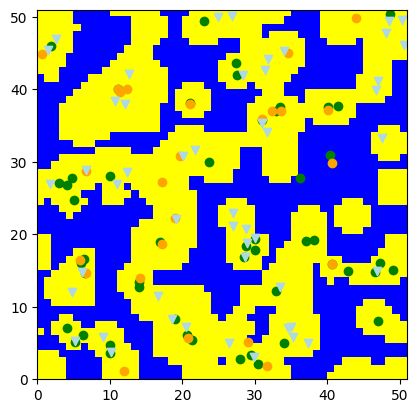

In [3]:
fig = plt.figure()
ax = fig.gca()
model.plot_agents(ax)


In [4]:

macro_state = model_macro_data(model)

print(
    "\n".join(
        map(
            lambda a: str(a[0]).ljust(8) + "\t" + str(int(a[1])).rjust(4),
            zip(
                ["empty", "healthy", "infected", "dead", "apoptosed"],
                macro_state[
                    [
                        state_var_indices["empty_epithelium_count"],
                        state_var_indices["healthy_epithelium_count"],
                        state_var_indices["infected_epithelium_count"],
                        state_var_indices["dead_epithelium_count"],
                        state_var_indices["apoptosed_epithelium_count"],
                    ]
                ],
            ),
        )
    )
)

empty   	   0
healthy 	1082
infected	1519
dead    	   0
apoptosed	   0


In [5]:
new_macro_state = macro_state.copy()
new_macro_state[state_var_indices["healthy_epithelium_count"]] += 300
new_macro_state[state_var_indices["infected_epithelium_count"]] -= 300

print(
    "\n".join(
        map(
            lambda a: str(a[0]).ljust(8) + "\t" + str(int(a[1])).rjust(4),
            zip(
                ["empty", "healthy", "infected", "dead", "apoptosed"],
                new_macro_state[
                    [
                        state_var_indices["empty_epithelium_count"],
                        state_var_indices["healthy_epithelium_count"],
                        state_var_indices["infected_epithelium_count"],
                        state_var_indices["dead_epithelium_count"],
                        state_var_indices["apoptosed_epithelium_count"],
                    ]
                ],
            ),
        )
    )
)

empty 0.0
healthy 1382.0
infected 1219.0
dead 0.0
apoptosed 0.0


In [6]:
from modify_epi_spatial import floyd_steinberg_dither, quantizer

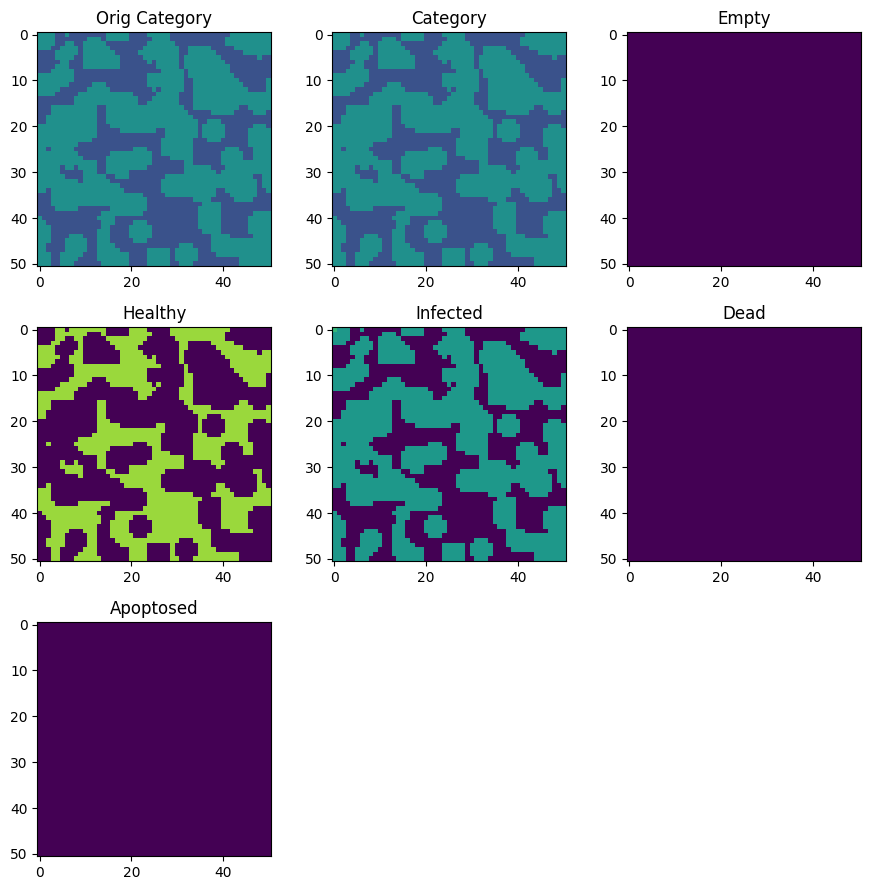

In [7]:
updated_epithelium, animation = floyd_steinberg_dither(
    model,
    new_macro_state[
        [
            state_var_indices["empty_epithelium_count"],
            state_var_indices["healthy_epithelium_count"],
            state_var_indices["infected_epithelium_count"],
            state_var_indices["dead_epithelium_count"],
            state_var_indices["apoptosed_epithelium_count"],
        ]
    ],
)

In [8]:
from IPython.display import HTML
HTML(animation.to_html5_video())
#HTML(animation.to_jshtml())

In [9]:
print("Prev Counts")
print(
    "\n".join(
        map(
            lambda a: str(a[0]).ljust(8) + "\t" + str(int(a[1])).rjust(4),
            zip(
                ["empty", "healthy", "infected", "dead", "apoptosed"],
                macro_state[
                    [
                        state_var_indices["empty_epithelium_count"],
                        state_var_indices["healthy_epithelium_count"],
                        state_var_indices["infected_epithelium_count"],
                        state_var_indices["dead_epithelium_count"],
                        state_var_indices["apoptosed_epithelium_count"],
                    ]
                ],
            ),
        )
    )
)
print()
print("New Counts")

print(
    "\n".join(
        map(
            lambda a: str(a[0]).ljust(8) + "\t" + str(a[1]).rjust(4),
            zip(
                ["empty", "healthy", "infected", "dead", "apoptosed"],
                [ np.sum(updated_epithelium == e) for e in range(5)],
            ),
        )
    )
)

Prev Counts
empty   	   0
healthy 	1082
infected	1519
dead    	   0
apoptosed	   0

New Counts
empty   	   0
healthy 	1082
infected	1519
dead    	   0
apoptosed	   0


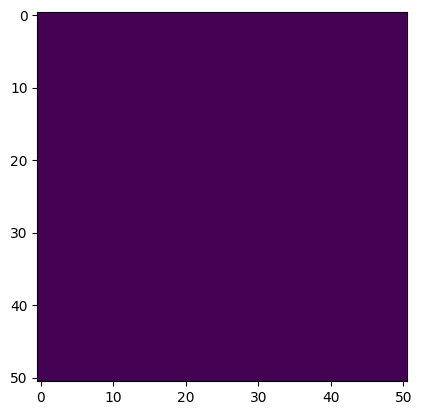

In [10]:
plt.imshow(updated_epithelium==3)